In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
from datetime import datetime
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
import glob
from PIL import Image
from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

Start import
Working on midway2-0420.rcc.local with the following versions 
and installation paths:
strax
	v0.15.0	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.1	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

In [4]:
def plot_area_width_aft_Kr(run_id, low = 0, high = 7, low2 = 0, high2 = 1, binning = 500,plot=False):
    events0 = st.get_df(run_id,'event_info_double',progress_bar=False)
    mask = mask_KrSingleS1(events0)
    livetime = (events0['time'][len(events0)-1]-events0['time'][0])/1e9
    events = events0[mask]
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    kr_rate = len(events)/livetime
    all_rate = len(events0)/livetime
    kr_rates, all_rates, slot_times = [], [], []
    for i in range(10):
        idx1, idx2 = int(i*(len(events0)-1)/10), int((i+1)*(len(events0)-1)/10)
        slot_time = (events0['time'][idx2]-events0['time'][idx1])/1e9
        trange = (events0['time']>events0['time'][idx1]) & (events0['time']<events0['time'][idx2])
        kr_rates = np.append(kr_rates,len(events0[mask & trange])/slot_time)
        all_rates = np.append(all_rates,len(events0[trange])/slot_time)
        timestamp = events0['time'][idx1]/1e9
        slot_times = np.append(slot_times,datetime.fromtimestamp(timestamp))
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
    plt.savefig(f'area_vs_aft_run{run_id}.png')
        
    if plot:
        plt.figure(figsize=(12,6))
        ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
        ph_s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("peak width 50% (ns)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
               
        plt.figure(figsize=(12,6))
        ph_s1s2 = Histdd(events['s1_a_area'], events['s2_a_area'],
                        bins=(np.logspace(0, 5, binning), np.logspace(1, 7, binning)))
        ph_s1s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("S1 peak area (PE)", ha='right', x=1)
        plt.ylabel("S2 peak area (PE)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
    
    print(f'run {run_id}, livetime {livetime:.2f} s, Kr-rate: {kr_rate:.2f} Hz')
    return kr_rate, all_rate, kr_rates, all_rates, slot_times

run 017665, livetime 1802.90 s, Kr-rate: 35.02 Hz


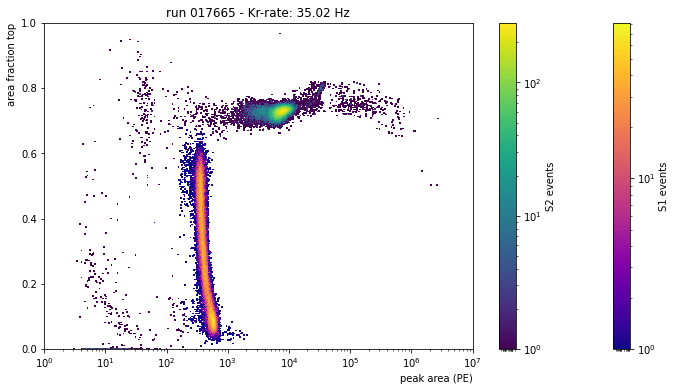

In [5]:
kr, aa, krs, ass, ss = plot_area_width_aft_Kr('017665',plot=0)

In [6]:
def plots_area_vs_aft(runs):
    kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = [], [], [], [], []
    for i, run in enumerate(runs):
        kr_rate, all_rate, krs, alls, slots = plot_area_width_aft_Kr(run,plot=0)
        slot_times = np.append(slot_times,slots)
        kr_rates = np.append(kr_rates,krs)
        all_rates = np.append(all_rates,alls)
        tot_kr_rates = np.append(tot_kr_rates,kr_rate)
        tot_all_rates = np.append(tot_all_rates,all_rate)
    fp_in = f'area_vs_aft_run*.png'
    fp_out = f'area_vs_aft_run{runs[0]}-{runs[-1]}.gif'
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=500, loop=0)
    for i, run in enumerate(runs):
        os.remove(f'area_vs_aft_run{run}.png')
    return kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates

run 017604, livetime 1801.61 s, Kr-rate: 0.21 Hz
run 017606, livetime 1800.02 s, Kr-rate: 0.27 Hz
run 017607, livetime 1801.50 s, Kr-rate: 0.43 Hz
run 017609, livetime 1801.89 s, Kr-rate: 0.76 Hz
run 017610, livetime 1801.85 s, Kr-rate: 1.24 Hz
run 017612, livetime 1800.09 s, Kr-rate: 1.89 Hz
run 017616, livetime 1800.53 s, Kr-rate: 2.64 Hz
run 017621, livetime 1802.83 s, Kr-rate: 3.44 Hz
run 017623, livetime 1800.82 s, Kr-rate: 4.31 Hz
run 017624, livetime 1800.93 s, Kr-rate: 5.18 Hz
run 017629, livetime 1801.31 s, Kr-rate: 5.83 Hz
run 017637, livetime 1800.74 s, Kr-rate: 6.93 Hz
run 017638, livetime 1801.06 s, Kr-rate: 7.29 Hz
run 017641, livetime 1801.28 s, Kr-rate: 7.84 Hz
run 017643, livetime 1800.29 s, Kr-rate: 9.98 Hz
run 017645, livetime 1802.25 s, Kr-rate: 13.70 Hz
run 017647, livetime 1801.64 s, Kr-rate: 17.35 Hz
run 017649, livetime 1802.61 s, Kr-rate: 20.99 Hz
run 017651, livetime 1802.95 s, Kr-rate: 24.14 Hz
run 017653, livetime 1803.22 s, Kr-rate: 26.88 Hz


<ipython-input-4-e483e9b543b6>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


run 017655, livetime 1801.24 s, Kr-rate: 29.26 Hz
run 017657, livetime 1800.23 s, Kr-rate: 31.24 Hz
run 017659, livetime 1802.03 s, Kr-rate: 32.37 Hz
run 017661, livetime 1800.58 s, Kr-rate: 33.52 Hz
run 017663, livetime 1802.28 s, Kr-rate: 34.47 Hz
run 017665, livetime 1802.90 s, Kr-rate: 35.02 Hz


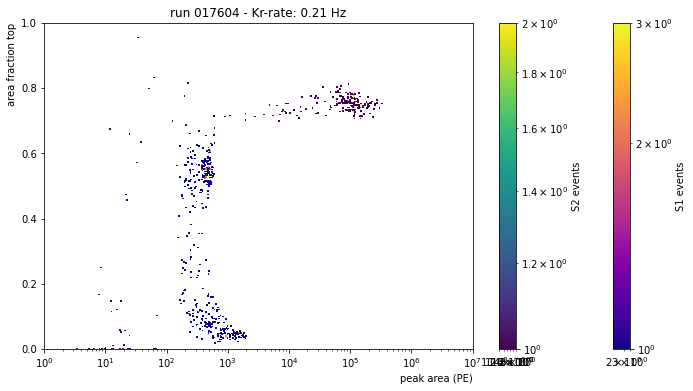

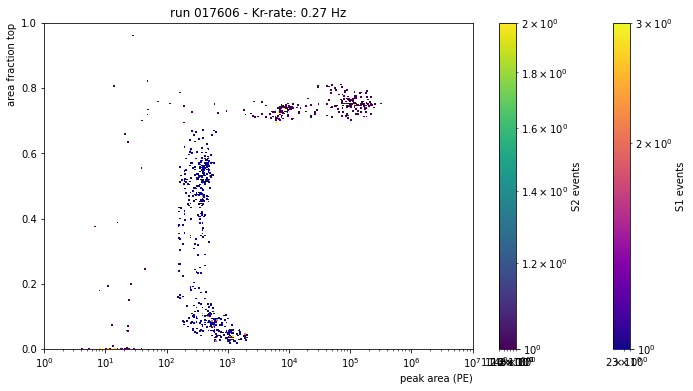

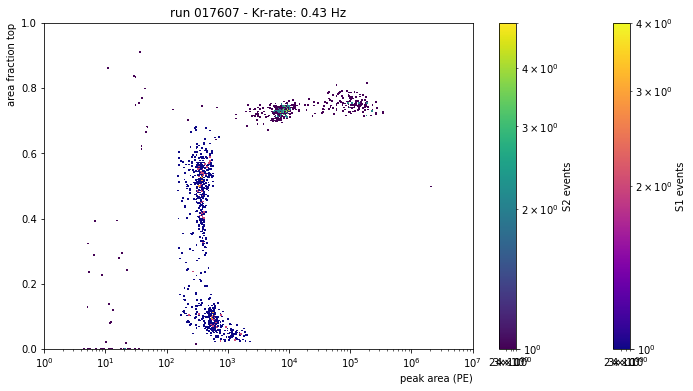

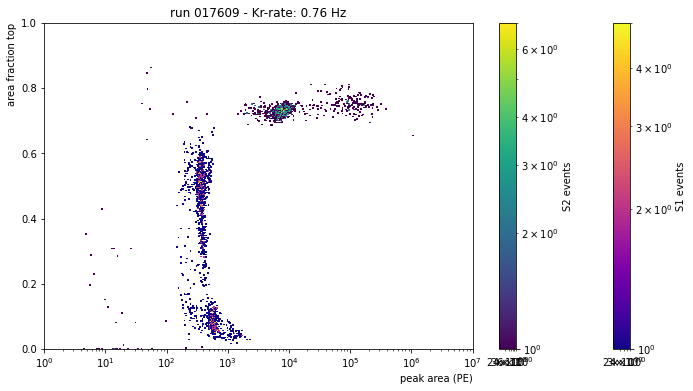

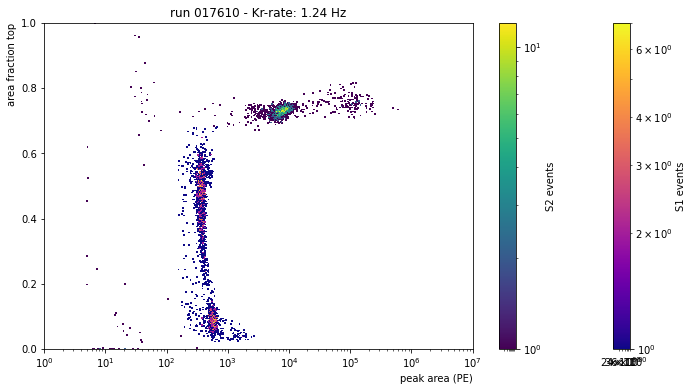

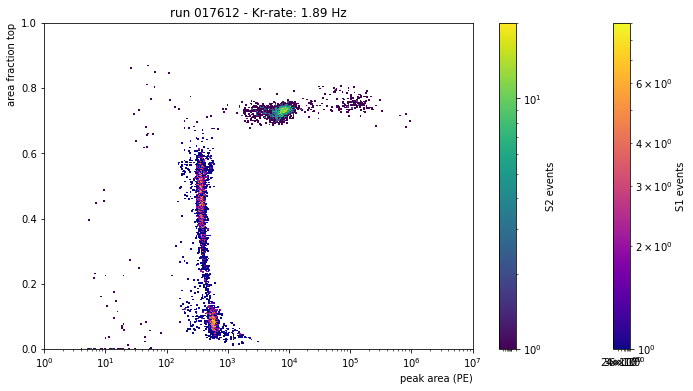

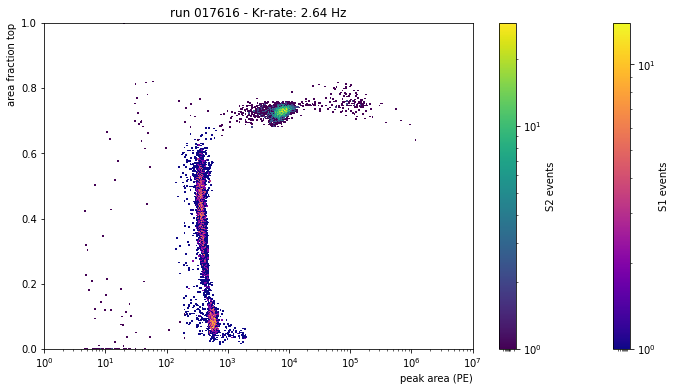

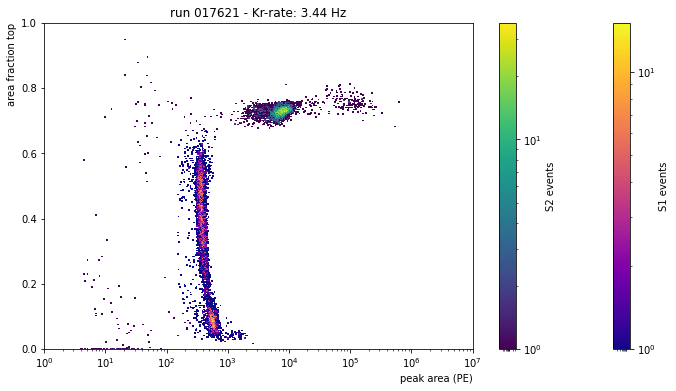

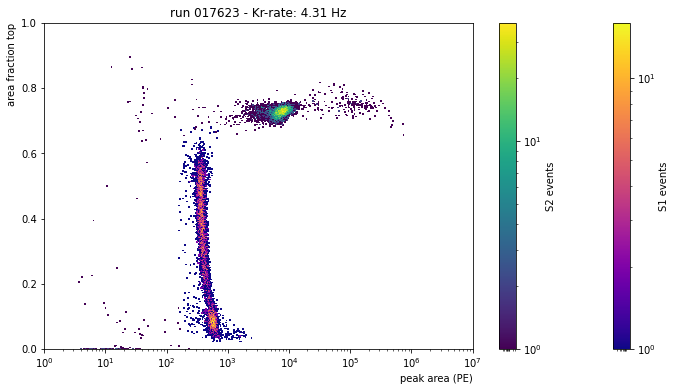

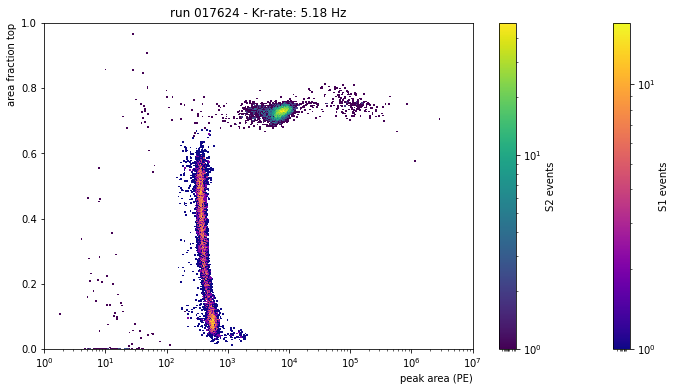

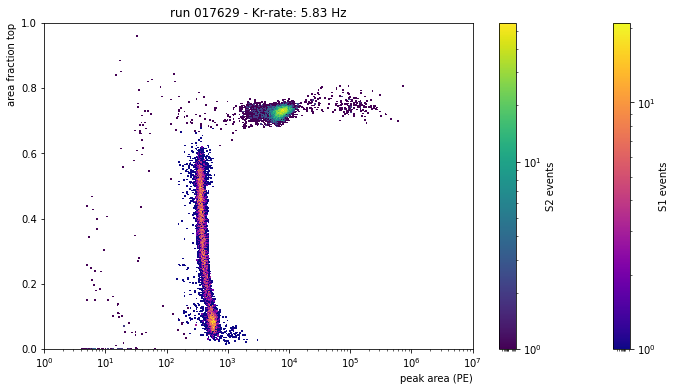

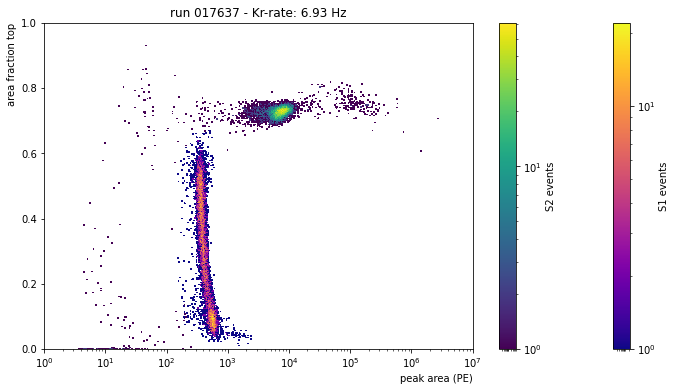

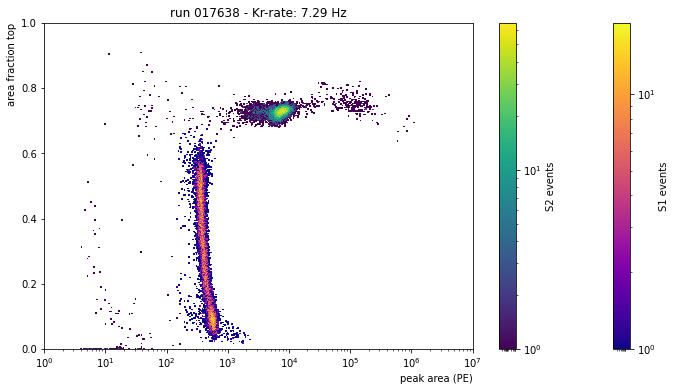

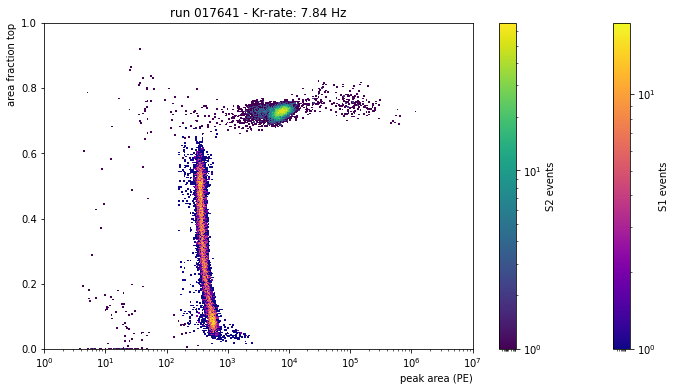

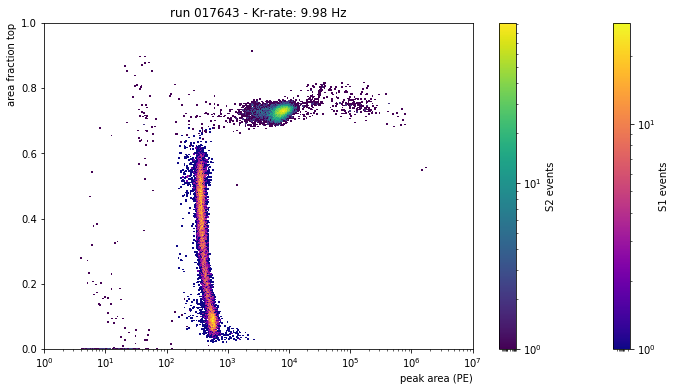

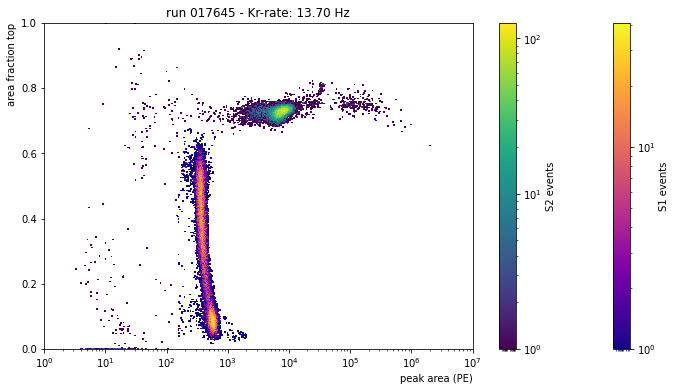

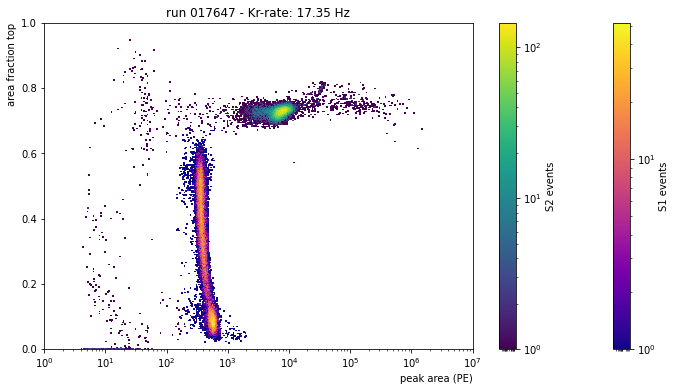

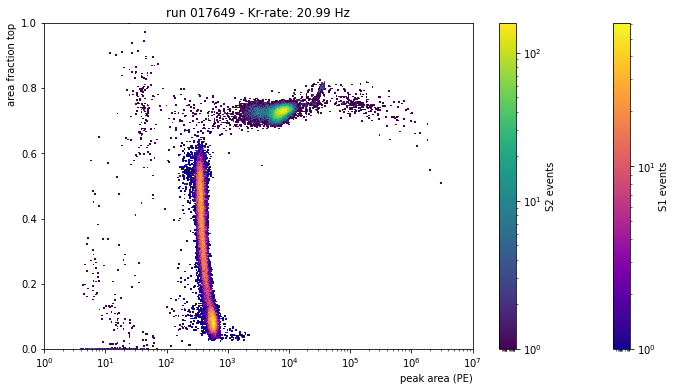

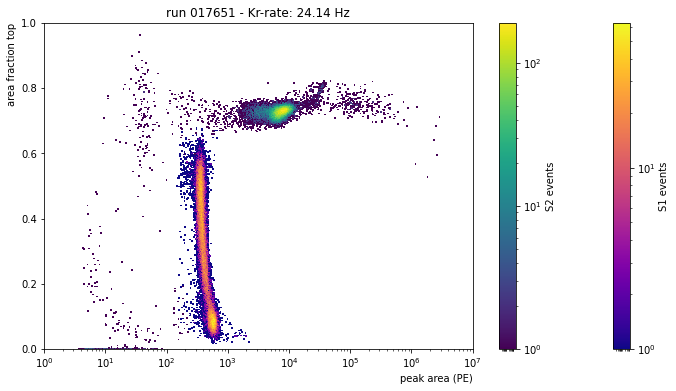

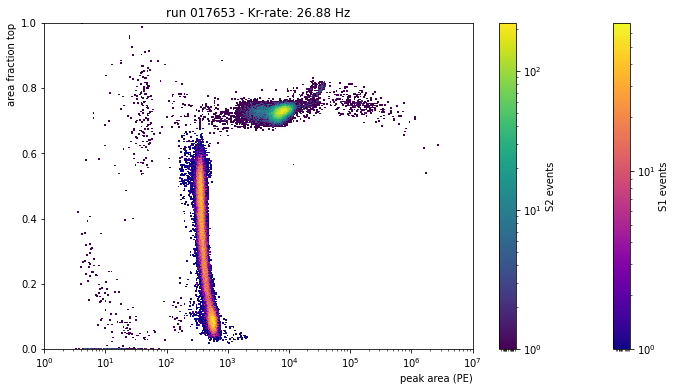

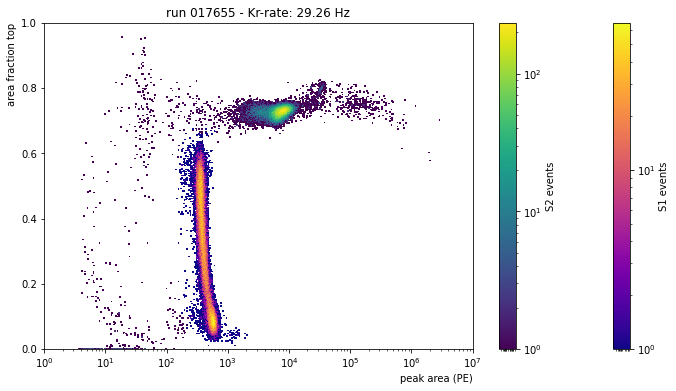

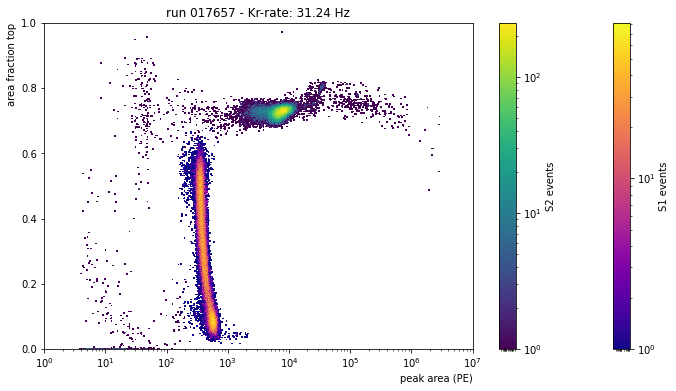

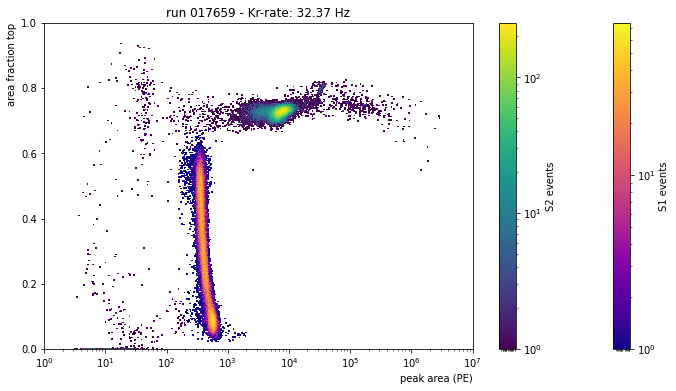

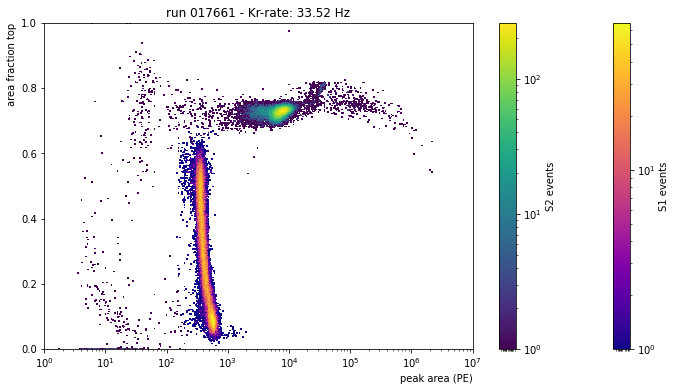

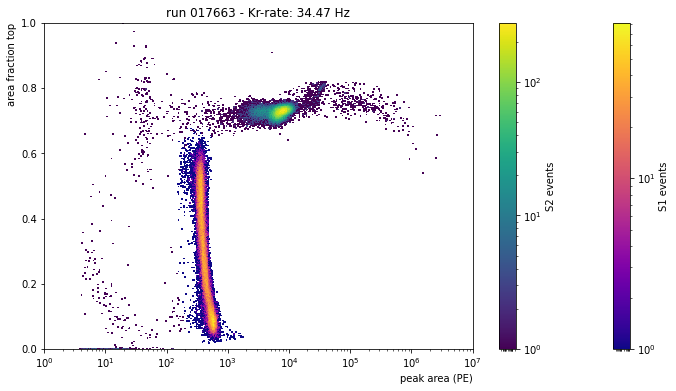

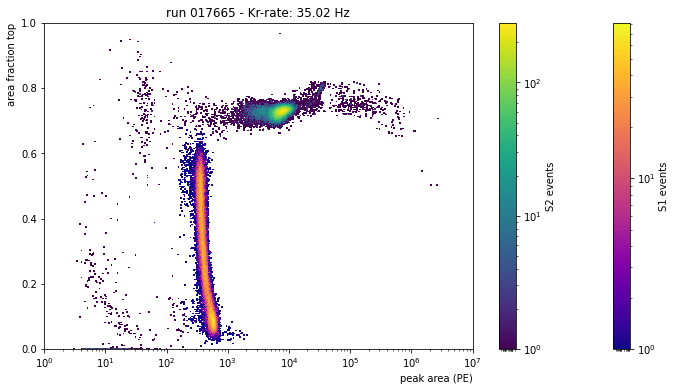

In [7]:
kr_runs = ['017604','017606','017607','017609','017610','017612','017616','017621',
           '017623','017624','017629','017637','017638','017641','017643','017645',
           '017647','017649','017651','017653','017655','017657','017659','017661',
           '017663','017665']
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=kr_runs)

In [2]:
from datetime import datetime, timedelta
plt.figure(figsize=(12,6))
dates = matplotlib.dates.date2num(slot_times + timedelta(hours=7))
plt.plot_date(dates, kr_rates,'.',label='Kr-83m rate')
plt.plot_date(dates, all_rates,'.',label='total rate')
plt.axvline(x = dates[22],color='black', linestyle = '--',label=f'valve at 0.2 turns')
plt.axvline(x = dates[52],color='m', linestyle = '--',label=f'valve at 0.4 turns')
plt.axvline(x = dates[83],color='b', linestyle = '--',label=f'valve at 0.8 turns')
plt.axvline(x = dates[130],color='r', linestyle = '--',label=f'valve at 3.2 turns')
myFmt = matplotlib.dates.DateFormatter('%d %b %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title(f'runs {kr_runs[0]} - {kr_runs[-1]}')
plt.xlabel("LNGS time", ha='right', x=1,fontsize=12)
plt.ylabel("Kr rate (Hz)", ha='right', y=1,fontsize=12)
plt.legend(fontsize=14)

NameError: name 'slot_times' is not defined

<Figure size 864x432 with 0 Axes>